In [1]:
#https://math.stackexchange.com/questions/3280757/differentiable-top-k-function\
#https://gist.github.com/thomasahle/4c1e85e5842d01b007a8d10f5fed3a18

import torch
from functorch import vmap, grad
from torch.autograd import Function

sigmoid = torch.sigmoid
sigmoid_grad = vmap(vmap(grad(sigmoid)))

class TopK(Function):
    @staticmethod
    def forward(ctx, xs, k):
        ts, ps = _find_ts(xs, k)
        ctx.save_for_backward(xs, ts)
        return ps

    @staticmethod
    def backward(ctx, grad_output):
        # Compute vjp, that is grad_output.T @ J.
        xs, ts = ctx.saved_tensors
        # Let v = sigmoid'(x + t)
        v = sigmoid_grad(xs + ts)
        s = v.sum(dim=1, keepdims=True)
        # Jacobian is -vv.T/s + diag(v)
        uv = grad_output * v
        t1 = - uv.sum(dim=1, keepdims=True) * v / s
        return t1 + uv, None

@torch.no_grad()
def _find_ts(xs, k):
    b, n = xs.shape
    assert 0 < k < n
    # Lo should be small enough that all sigmoids are in the 0 area.
    # Similarly Hi is large enough that all are in their 1 area.
    lo = -xs.max(dim=1, keepdims=True).values - 10
    hi = -xs.min(dim=1, keepdims=True).values + 10
    for _ in range(64):
        mid = (hi + lo)/2
        mask = sigmoid(xs + mid).sum(dim=1) < k
        lo[mask] = mid[mask]
        hi[~mask] = mid[~mask]
    ts = (lo + hi)/2
    return ts, sigmoid(xs + ts)

topk = TopK.apply
xs = torch.randn(2, 3)
ps = topk(xs, 2)
print(xs, ps, ps.sum(dim=1))

from torch.autograd import gradcheck
input = torch.randn(20, 10, dtype=torch.double, requires_grad=True)
for k in range(1, 10):
    print(k, gradcheck(topk, (input, k), eps=1e-6, atol=1e-4))

tensor([[-0.1256,  0.2888,  1.6974],
        [ 1.5481,  1.6830, -1.1004]]) tensor([[0.5153, 0.6167, 0.8681],
        [0.8493, 0.8657, 0.2850]]) tensor([2., 2.])
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True


In [72]:
# Test speed
xs = torch.abs(torch.randn(40,500).float().cuda())
xsorig = xs.detach().clone()
for _ in range(2):
    ps = topk(xs, 20)
    xs = ps*xs

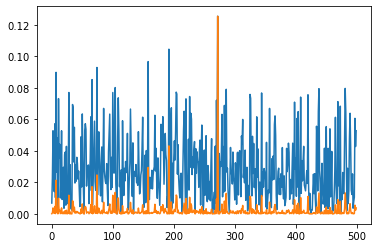

In [73]:
import matplotlib.pyplot as plt

mxs, _ = torch.max(xs, dim=1, keepdim=True)
mxsorig, _ = torch.max(xsorig, dim=1, keepdim=True)

plt.plot((xsorig*mxs/mxsorig)[0].detach().cpu().numpy())
plt.plot(xs[0].detach().cpu().numpy())
plt.show()

In [69]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [61]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [62]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [63]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [64]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [65]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [66]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

mu_age = torch.mean(age_t)
sd_age = torch.std(age_t)

age_t = (age_t - mu_age)

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    avg = 0
    for para in range(nPara):
        avg += res[para]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, nTasks, inp, dp=0.5, edp=0, wInit=1e-4, k=20, kIter=1):
        super(LatSim, self).__init__()
        self.nTasks = nTasks
        self.B = nn.Parameter(wInit*torch.randn(2,inp.shape[-1],dimB).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        
    def getEdges(self, X, para):
        e = 1e-10
        z = X[:,para,:]@self.B[para]
        e = e+z@z.T
        return e
    
    def forward(self, x, ys, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for para in range(2):
            e = self.getEdges(x, para)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = mask(e)
            e = self.edp(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e/self.t[task], dim=1)
            for _ in range(self.kIter):
                p = topk(e, self.k)
                e = p*e
            res.append(e@y)
            es.append(e)
        return res, es
    
def validate(model, X, ys, testIdcs):
    model.eval()
    losses = []
    with torch.no_grad():
        res, _ = model(X, ys, testIdcs)
        for r,y in zip(getAvg(res), ys):
            if y.dim() == 1:
                loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
                losses.append(loss)
            else:
                corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
                losses.append(loss)
    model.train()
    return losses
    
nEpochs = 1000
pPeriod = 50
thresh = [20,0.3,10]
regParam = [1,1e3,20]
binParam = 0

for rep in range(1):
    for grp in range(1):
        trainIdcs = groups[grp][0][0:496]
        trainValidIdcs = groups[grp][0]
        validIdcs = np.arange(496,len(trainValidIdcs))
        testIdcs = groups[grp][1]

        X0 = nback_p_t
        X1 = emoid_p_t

        X = torch.stack([X0, X1], dim=1)
        Xt = X[trainIdcs]
        Xtv = X[trainValidIdcs]

        yy = [age_t, gen_t, wrt_t]
        yt = [age_t[trainIdcs], gen_t[trainIdcs], wrt_t[trainIdcs]]
        ytv = [age_t[trainValidIdcs], gen_t[trainValidIdcs], wrt_t[trainValidIdcs]]

    #     yy = yy[2:]
    #     yt = yt[2:]
    #     ytv = ytv[2:]

        nTasks = len(yy)

        sim = LatSim(nTasks, X, dp=0.5, edp=0.1, adp=0.3, wInit=1e-4, dimA=20, dimB=2, temp=[1,1,1])
        optim = torch.optim.Adam(sim.parameters(), lr=5e-4, weight_decay=5e-4)

        validLoss = [[] for _ in range(nTasks)]

        for epoch in range(nEpochs):
            optim.zero_grad()
            res, As, _ = sim(Xt, yt)
            loss = []
            for i,(r,y) in enumerate(zip(flatten(res)+getAvg(res), (X.shape[1]+1)*yt)):
                if y.dim() > 1:
                    loss.append(regParam[i%nTasks]*ceLoss(r, y))
                else:
                    loss.append(regParam[i%nTasks]*mseLoss(r, y))
            bloss = [binParam*binLoss(sim.A)]
            loss += bloss
            sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or allBelowThresh(loss[0:nTasks], thresh):
                print(f'epoch {epoch} loss={bloss}')
                losses = validate(sim, Xtv, ytv, validIdcs)
                for i,lss in enumerate(losses):
                    if (len(validLoss[i]) == 0 or 
                            (yy[i].dim() == 1 and lss < min(validLoss[i])) or 
                            (yy[i].dim() > 1 and lss > max(validLoss[i]))):
                        print(f'New best validation epoch {epoch} {i} loss={lss}')
                        torch.save(sim.state_dict(), f'../../Work/LatentSim/sim{i}.pyt')
                        validLoss[i].append(float(lss))
                if allBelowThresh(loss[0:nTasks], thresh):
                    print('Early stopping')
                    break

        finalLoss = []
        featPart = np.zeros((2,nTasks,34716))

        for task in range(nTasks):
            sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))
            loss = validate(sim, X, yy, testIdcs)
            finalLoss.append(float(loss[task]))

#             for para in range(2):
#                 feat = getFeatures(sim, X, yy, task, para, testIdcs)
#                 featPart[para,task] = feat.detach().cpu().numpy()

        rmse.append(finalLoss)
        features.append(np.stack(featPart))

        print(f'FINISHED {rmse}')